# Dynamic Quantization with Hugging Face Optimum

{{ badge }}

## Learning objectives

## Setup

In [ ]:
%pip install "optimum[onnxruntime]==1.2.2" evaluate

In [177]:
from huggingface_hub import notebook_login

notebook_login()

## Imports

In [1]:
import os
from pathlib import Path
from time import perf_counter

import numpy as np
from datasets import load_dataset
from evaluate import evaluator
from optimum.onnxruntime import (
    ORTModelForSequenceClassification,
    ORTOptimizer,
    ORTQuantizer,
)
from optimum.onnxruntime.configuration import AutoQuantizationConfig, OptimizationConfig
from optimum.pipelines import pipeline
from transformers import AutoTokenizer
from transformers import pipeline as transformers_pipeline
import matplotlib.pyplot as plt

In [2]:
import datasets
import evaluate

datasets.logging.set_verbosity_error()
evaluate.logging.set_verbosity_error()

## Load dataset and fine-tuned model

In [3]:
dataset = load_dataset("banking77", split="test")

In [4]:
model_id = "optimum/distilbert-base-uncased-finetuned-banking77"
classifier = transformers_pipeline("text-classification", model=model_id)

### Evaluate the model

In [6]:
label_mapping = classifier.model.config.label2id
eval_pipe = evaluator("text-classification")

baseline_metrics = eval_pipe.compute(
    model_or_pipeline=classifier,
    data=dataset,
    metric="accuracy",
    input_column="text",
    label_column="label",
    label_mapping=label_mapping,
    strategy="simple",
)
baseline_metrics

{'accuracy': 0.925}

In [154]:
def time_pipeline(pipeline, dataset, num_samples=100):
    sample_ds = dataset.shuffle(seed=42).select(range(num_samples))
    latencies = []
    # Timed run
    for sample in sample_ds:
        start_time = perf_counter()
        _ = pipeline(sample["text"])
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

In [155]:
baseline_latency = time_pipeline(classifier, dataset)

Average latency (ms) - 60.44 +\- 16.43


## Dynamic quantization

In [95]:
onnx_path = Path("onnx")
task = "sequence-classification"

In [96]:
# load vanilla transformers and convert to onnx
model = ORTModelForSequenceClassification.from_pretrained(
    model_id, from_transformers=True
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Downloading:   0%|          | 0.00/5.81k [00:00<?, ?B/s]

In [100]:
# save onnx checkpoint and tokenizer
model.save_pretrained(onnx_path)
tokenizer.save_pretrained(onnx_path)

('onnx/tokenizer_config.json',
 'onnx/special_tokens_map.json',
 'onnx/vocab.txt',
 'onnx/added_tokens.json',
 'onnx/tokenizer.json')

In [99]:
# create ORTOptimizer and define optimization configuration
dynamic_optimizer = ORTOptimizer.from_pretrained(model_id, feature=task)
dynamic_optimization_config = OptimizationConfig(
    optimization_level=99
)  # enable all optimizations

In [101]:
# apply the optimization configuration to the model
model_optimized_path = dynamic_optimizer.export(
    onnx_model_path=onnx_path / "model.onnx",
    onnx_optimized_model_output_path=onnx_path / "model-optimized.onnx",
    optimization_config=dynamic_optimization_config,
)
model_optimized_path

2022-06-06 15:29:38.500689 [W:onnxruntime:, inference_session.cc:1546 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


PosixPath('onnx/model-optimized.onnx')

In [102]:
!ls {onnx_path}

config.json             model.onnx              tokenizer_config.json
model-optimized.onnx    special_tokens_map.json vocab.txt
model-quantized.onnx    tokenizer.json


In [170]:
# create ORTQuantizer and define quantization configuration
dynamic_quantizer = ORTQuantizer.from_pretrained(model_id, feature=task)
dqconfig = AutoQuantizationConfig.avx512_vnni(is_static=False, per_channel=True)

# apply the quantization configuration to the model
model_quantized_path = dynamic_quantizer.export(
    onnx_model_path=onnx_path / "model-optimized.onnx",
    onnx_quantized_model_output_path=onnx_path / "model-quantized-dynamic.onnx",
    quantization_config=dqconfig,
)

In [171]:
!ls {onnx_path}

config.json                  special_tokens_map.json
model-optimized.onnx         tokenizer.json
model-quantized-dynamic.onnx tokenizer_config.json
model-quantized.onnx         vocab.txt
model.onnx


In [172]:
# get model file size
size = os.path.getsize(onnx_path / "model.onnx") / (1024 * 1024)
print(f"Vanilla Onnx Model file size: {size:.2f} MB")
size = os.path.getsize(onnx_path / "model-quantized-dynamic.onnx") / (1024 * 1024)
print(f"Quantized Onnx Model file size: {size:.2f} MB")

Vanilla Onnx Model file size: 255.68 MB
Quantized Onnx Model file size: 164.67 MB


In [173]:
model = ORTModelForSequenceClassification.from_pretrained(
    onnx_path, file_name="model-quantized-dynamic.onnx"
)

In [179]:
model_id

'optimum/distilbert-base-uncased-finetuned-banking77'

In [182]:
# Would be cool to get the URL like in transformers
model.push_to_hub(save_directory="onnx", repository_id="distilbert-base-uncased-finetuned-banking77", use_auth_token=True)

/Users/lewtun/miniconda3/envs/hf/lib/python3.9/site-packages/huggingface_hub/hf_api.py:79: FutureWarning: `name` and `organization` input arguments are deprecated and will be removed in v0.8. Pass `repo_id` instead.
  warnings.warn(


In [106]:
ort_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [107]:
ort_classifier("I want to pay a new car")

[{'label': 'request_refund', 'score': 0.24217796325683594}]

In [108]:
quantized_results = eval_pipe.compute(
    model_or_pipeline=ort_classifier,
    data=dataset,
    metric="accuracy",
    input_column="text",
    label_column="label",
    label_mapping=label_mapping,
    strategy="simple",
)
quantized_results

CPU times: user 2min 22s, sys: 694 ms, total: 2min 23s
Wall time: 29.9 s


{'accuracy': 0.9227272727272727}

In [156]:
quantized_latency = time_pipeline(ort_classifier, dataset)

Average latency (ms) - 9.14 +\- 3.37


In [166]:
quantized_latency

{'time_avg_ms': 9.13620000004812, 'time_std_ms': 3.371496491458507}

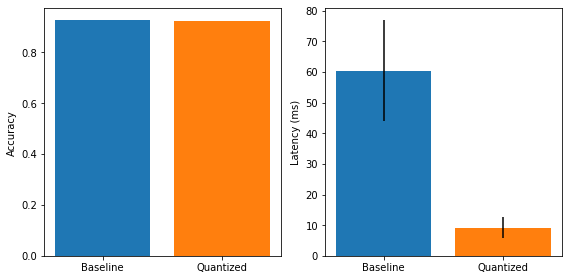

In [169]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(8, 4))
ax0.bar(x="Baseline", height=baseline_results["accuracy"])
ax0.bar(x="Quantized", height=quantized_results["accuracy"])
ax0.set_ylabel("Accuracy")

ax1.bar(x="Baseline", height=baseline_latency["time_avg_ms"], yerr=baseline_latency["time_std_ms"])
ax1.bar(x="Quantized", height=quantized_latency["time_avg_ms"], yerr=quantized_latency["time_std_ms"])
ax1.set_ylabel("Latency (ms)")


plt.tight_layout()